# Imports

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import os
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

cpu


In [15]:
if device.type == "cuda":
  !cp -r "/content/drive/MyDrive/Projects/chest_xray" "./"

# Transforms

In [16]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Datasets and Dataloaders

Note: There's actually ~3x more pneumonia x-rays than normal x-rays

In [17]:
class XRayDataset(utils.data.Dataset):
    def __init__(self, path, transforms=None):
        self.transforms = transforms
        self.samples = []  # Precompute list of (filepath, label)

        # Build list once
        for label, class_name in enumerate(["NORMAL", "PNEUMONIA"]):
            class_dir = os.path.join(path, class_name)
            for filename in os.listdir(class_dir):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(class_dir, filename), label))

        print(f"Normal Samples: {len([s for s in self.samples if s[1] == 0])}")
        print(f"Pneumonia Samples: {len([s for s in self.samples if s[1] == 1])}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
        return image, label

train_dataset = XRayDataset(path="./chest_xray/train", transforms=transforms_train)
test_dataset = XRayDataset(path="./chest_xray/test", transforms=transforms_val)

if device == "cuda":
    train_loader = utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
else:
    train_loader = utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    test_loader = utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(len(train_dataset))
print(len(test_dataset))

Normal Samples: 1349
Pneumonia Samples: 3883
Normal Samples: 234
Pneumonia Samples: 390
5232
624


#  Image Examples

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


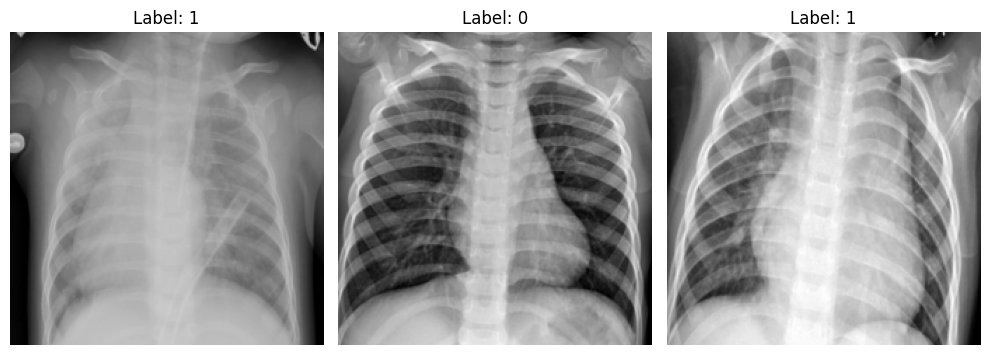

In [7]:

examples_iter = iter(train_loader)
images, labels = next(examples_iter)

plt.figure(figsize=(10,4))
for i in range(3):
    img = images[i]
    print(img.shape)
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Load Pretrained Model

In [8]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(in_features=512, out_features=2) # Replace last layer with output features of 2 to match our classes.
model.to(device)

"Model has been set up."


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s]


'Model has been set up.'

# Feature Extraction

Training classifier head only.

## Setup

In [9]:
for param in model.parameters():
    param.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, eta_min=1e-5, T_0=10, T_mult=2)
criterion = nn.CrossEntropyLoss()

metrics = {"train_loss": [], "val_acc": []}
best_val_acc = 0

## Train Loop

In [10]:
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_acc = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model(X)
            acc = y_pred.argmax(dim=1) == y
            val_acc += acc.sum().item()

    train_loss = train_loss / len(train_loader)
    val_acc = val_acc / len(test_dataset)

    metrics["train_loss"].append(train_loss)
    metrics["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model": model.state_dict(),
            "metrics": metrics,
        }, "best_model_feature_extraction.pth")

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

torch.save({
    "model": model.state_dict(),
    "metrics": metrics,
}, "final_model_feature_extraction.pth")

Epoch 1/10, Train Loss: 0.3040, Val Acc: 0.7099
Epoch 2/10, Train Loss: 0.1735, Val Acc: 0.8093
Epoch 3/10, Train Loss: 0.1481, Val Acc: 0.7981
Epoch 4/10, Train Loss: 0.1360, Val Acc: 0.7372
Epoch 5/10, Train Loss: 0.1307, Val Acc: 0.8157
Epoch 6/10, Train Loss: 0.1330, Val Acc: 0.7772
Epoch 7/10, Train Loss: 0.1210, Val Acc: 0.8205
Epoch 8/10, Train Loss: 0.1143, Val Acc: 0.7756
Epoch 9/10, Train Loss: 0.1081, Val Acc: 0.8269
Epoch 10/10, Train Loss: 0.1112, Val Acc: 0.8173


# Additional Fine-Tuning

Train a few more epochs with added fine-tuning (unfreezing the backbone)

In [11]:
for param in model.parameters():
    param.requires_grad = True

fc_params = list(model.fc.parameters())
fc_param_ids = set(id(p) for p in fc_params)

other_params = [p for p in model.parameters() if id(p) not in fc_param_ids]

optimizer = optim.Adam([
    {"params": other_params, "lr": 0.00001},
    {"params": fc_params, "lr": 0.001}
])

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, eta_min=1e-5, T_0=10, T_mult=2)

## Training Loop

In [12]:
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss = 0
    val_acc = 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            y_pred = model(X)
            acc = y_pred.argmax(dim=1) == y
            val_acc += acc.sum().item()

    train_loss = train_loss / len(train_loader)
    val_acc = val_acc / len(test_dataset)

    metrics["train_loss"].append(train_loss)
    metrics["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model": model.state_dict(),
            "metrics": metrics,
        }, "best_model_additional_finetuning.pth")

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

torch.save({
    "model": model.state_dict(),
    "metrics": metrics,
}, "final_model_additional_finetuning.pth")

Epoch 1/5, Train Loss: 0.0857, Val Acc: 0.8205
Epoch 2/5, Train Loss: 0.0491, Val Acc: 0.7516
Epoch 3/5, Train Loss: 0.0340, Val Acc: 0.8558
Epoch 4/5, Train Loss: 0.0217, Val Acc: 0.8157
Epoch 5/5, Train Loss: 0.0143, Val Acc: 0.8638


# Load Datasets

Trained on Colab using T4 GPU. Local evaluation here on CPU.

In [11]:
feature_extraction_model = models.resnet18(weights=None)
feature_extraction_model.fc = nn.Linear(in_features=512, out_features=2)
fine_tuned_model = models.resnet18(weights=None)
fine_tuned_model.fc = nn.Linear(in_features=512, out_features=2)

# This is the final model from the feature extraction training (After the last epoch).
feature_extraction_checkpoint = torch.load("final_model_feature_extraction.pth", map_location=device)

# This is the best model from the additional fine-tuning training.
fine_tuned_checkpoint = torch.load("best_model_additional_finetuning.pth", map_location=device)

feature_extraction_model.load_state_dict(feature_extraction_checkpoint["model"])
fine_tuned_model.load_state_dict(fine_tuned_checkpoint["model"])

feature_extraction_model.to(device)
fine_tuned_model.to(device)

"Loaded models successfully."

'Loaded models successfully.'

# Final Evaluation and Reporting

In [21]:
with torch.no_grad():
    feature_extraction_model.eval()
    fine_tuned_model.eval()

    feature_extraction_preds = []
    fine_tuned_preds = []
    true_labels = []

    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        feature_extraction_pred = feature_extraction_model(X)
        fine_tuned_pred = fine_tuned_model(X)

        feature_extraction_preds.append(feature_extraction_pred.argmax(dim=1))
        fine_tuned_preds.append(fine_tuned_pred.argmax(dim=1))
        true_labels.append(y)

    feature_extraction_preds = torch.cat(feature_extraction_preds)
    fine_tuned_preds = torch.cat(fine_tuned_preds)
    true_labels = torch.cat(true_labels)


## Final Accuracy

In [22]:
feature_extraction_acc = (feature_extraction_preds == true_labels).float().mean()
fine_tuned_acc = (fine_tuned_preds == true_labels).float().mean()

print(f"Feature Extraction Accuracy: {feature_extraction_acc:.4f}")
print(f"Fine-Tuned Accuracy: {fine_tuned_acc:.4f}")

Feature Extraction Accuracy: 0.8173
Fine-Tuned Accuracy: 0.8638


## Training / Validation Metric Visualization

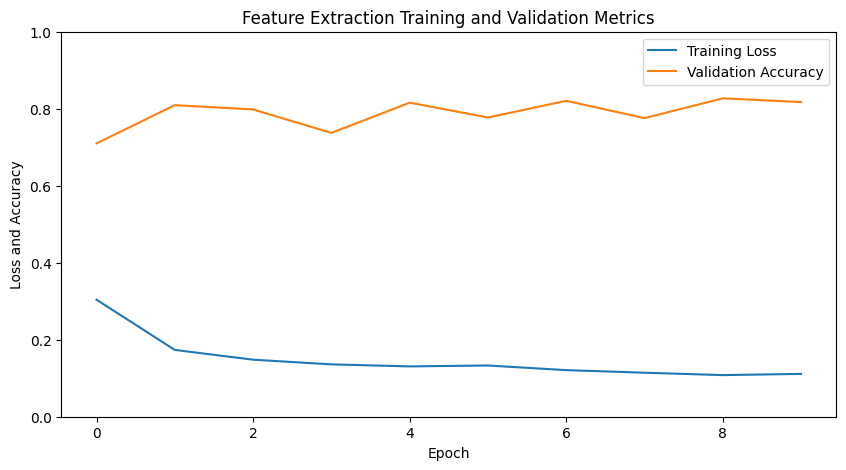

In [31]:
feature_extraction_metrics = feature_extraction_checkpoint["metrics"]
fine_tuned_metrics = fine_tuned_checkpoint["metrics"]

plt.figure(figsize=(10,5))
plt.plot(feature_extraction_metrics["train_loss"])
plt.plot(feature_extraction_metrics["val_acc"])
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend(["Training Loss", "Validation Accuracy"])
plt.title("Feature Extraction Training and Validation Metrics")
plt.show()

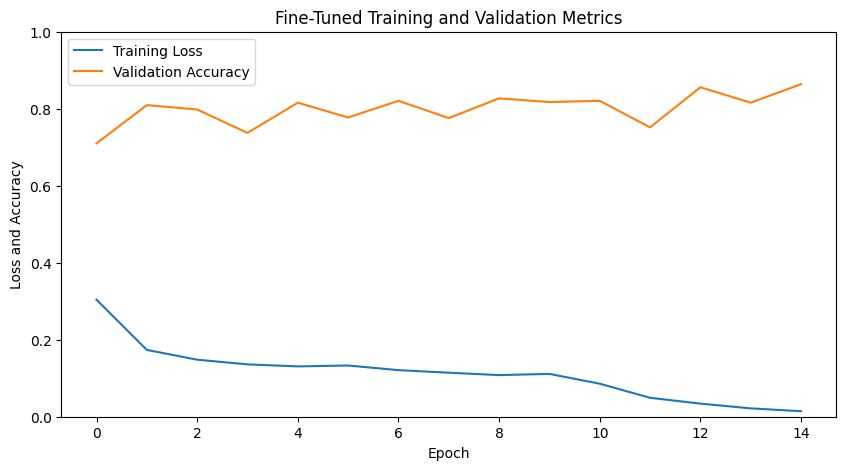

In [32]:
plt.figure(figsize=(10,5))
plt.plot(fine_tuned_metrics["train_loss"])
plt.plot(fine_tuned_metrics["val_acc"])
plt.ylim(0, 1)
plt.xlabel("Epoch")
plt.ylabel("Loss and Accuracy")
plt.legend(["Training Loss", "Validation Accuracy"])
plt.title("Fine-Tuned Training and Validation Metrics")
plt.show()

# Summary

This notebook implements a two-stage transfer learning approach using pretrained ResNet18 on chest X-ray images (Normal vs. Pneumonia). Stage 1 freezes the backbone and trains only the classifier head for 10 epochs, achieving 81.73% accuracy. Stage 2 unfreezes all parameters and fine-tunes with differential learning rates (backbone: 1e-5, head: 1e-3) for 5 additional epochs, improving to 86.38% accuracy. The implementation demonstrates proper parameter freezing/unfreezing, checkpointing, and shared metrics tracking across both training stages.